# PROJECT: Course Optimization for Data Science
## Optimization strategies for Support Vector Machines (SVM)

Authors: Alexandre Gramfort, Stéphane Gaiffas

If you have questions or if something is not clear in the text below please contact us
by email.

## Aim:

- derive the duals for SVMs with and without intercept
- implement an SVM using a blackbox convex toolbox (cvxopt in Python)
- implement your own solvers for the without intercept case: Proximal gradient, Coordinate Descent, Newton, Quasi-Newton
- Present a clear benchmark of the different strategies on small and medium scale datasets


## VERY IMPORTANT

This work must be done by pairs of students.
Each student must send their work before the 3rd of January at 23:59, using the moodle platform.
This means that **each student in the pair sends the same file**

On the moodle, in the "Optimization for Data Science" course, you have a "devoir" section called "Project".
This is where you submit your jupyter notebook file.

The name of the file must be constructed as in the next cell

### Gentle reminder: no evaluation if you don't respect this EXACTLY

#### How to construct the name of your file

In [1]:
# Change here using YOUR first and last names
fn1 = "peter"
ln1 = "martigny"
fn2 = "benoît"
ln2 = "choffin"

filename = "_".join(map(lambda s: s.strip().lower(), 
                        ["project", ln1, fn1, "and", ln2, fn2])) + ".ipynb"
print(filename)

project_martigny_peter_and_choffin_benoît.ipynb


Some imports

In [2]:
%matplotlib inline
import numpy as np
from scipy import linalg
import time
import matplotlib.pyplot as plt

## Important:

For Part 0 to Part 2 of the project you will need a working install of `cvxopt`.
You may struggle a bit to set it up.
The simplest way of getting it is by typing 

`pip install cvxopt`

if you have `pip` installed on your laptop.
If you **struggle too much please
contact us**.

## Part 0: SVM Classification with linear kernel

Let us consider the problem of binary classification from $n$ observations
$x_i \in \mathbb{R}^{d}$,
$1 \leq i \leq n$. We aim to learn a function:
$$f: x \in \mathbb{R}^{d}\mapsto y\in\{-1,+1\}$$
from the $n$ annotated training samples $(x_{i},y_{i})$ supposed i.i.d. from an unknown probability distribution on $\mathbb{R}^d \times \{-1,+1\}$. Once this function is learnt, it will be possible to use it to predict the label $y$ associated to a new sample $x$.

Margin and linear separating hyperplane:

<img src="separateur.png">

In the linear case, one looks for an affine function of $x$ of the form 
$f(x) = \mathrm{sign}(w^{\top} x)$ or $f(x)=\mathrm{sign}(w^{\top}x + b)$
with $w \in \mathbb{R}^d$ and $b \in \mathbb{R}$. The first case is referred
to as the **without intercept** case. Indeed the coefficient $b$ is known
as the intercept or bias term.

We will start by considering the case with intercept.

To learn $f$, we use the $n$ annotated samples and one looks for a hyperplane $P(w,b)$
such that the smallest distance to positive and negative samples
is the largest. This can be written as:
$$
 \max_{w,b} \min_{i=1:n} y_i \delta(x_{i},P(w,b)) \quad
 \text{where}\quad \delta(x_{i},w,b) = \frac{w^{\top}x_{i}+b}{\sqrt{w^{\top}w}} \enspace,
$$
since the signed distance from a sample $x_{i}$ to the hyperplane $P(w,b)$ is given by
$
\delta(x_{i},w,b)
$.
The principle described above is the maximisation of the *margin*.

One can notice that if the minimum of a set of values is larger than $m$ then all values of the set are larger than $m$. This leads to the following problem formulation:
$$
 \left\{
 \begin{array}{cll}
 \max_{(w,b)} \quad m \\
 \text{s.t.} \;\; &\forall i &y_i\dfrac{w^{\top}x_{i}+b}{\sqrt{w^{\top}w}}\geq m
 \end{array}
 \right. \enspace .
$$

The hyperplane separates the space in 2 half spaces, depending if $\delta(x_{i},w,b)$ is positive or negative.

Assuming all samples are linearly separable, convince yourself that the problem can be written as:
$$
(\mathcal{P}):  \left\{
 \begin{array}{cll}
 &\min_{(w,b)} \frac{1}{2}w^{\top}w
 \\
  &y_{i}(w^{\top}x_{i}+b)\geq 1, \quad \forall i\in \{1,\cdots,n\}
 \end{array}
 \right.
$$

### Questions

- Q1: Justify that the problem $(\mathcal{P})$ is convex.

Let us first demonstrate that $C = \{w \: | \: y_i(w^Tx_i + b) \geq 1 \: \forall i \in \{1,...,n\}\}$ is a convex set.

Let us take $\alpha \in [0,1]$ and $s$ and $t$ two elements of $C$. Then, we have:
$$y_i(s^Tx_i + b) \geq 1$$
and:
$$y_i(t^Tx_i + b) \geq 1$$
By multiplying these two inequalities by respectively $\alpha$ and $1 - \alpha$, we get:
$$\alpha y_i(s^Tx_i + b) \geq \alpha$$
and:
$$(1-\alpha)y_i(t^Tx_i + b) \geq (1-\alpha)$$
Summing these last inequalities leads us to:
$$\alpha y_i (s^Tx_i + b) + (1 - \alpha)y_i(t^Tx_i + b) \geq 1 \iff y_i(\alpha(s^Tx_i + b) + (1-\alpha)(t^Tx_i + b)) \geq 1$$
$$\iff y_i(\alpha s^Tx_i + \alpha b + (1-\alpha)t^Tx_i + (1-\alpha)b) \geq 1 \iff y_i((\alpha s + (1-\alpha)t)^Tx_i + b) \geq 1$$
We conclude that for any $\alpha \in [0,1]$, for any $s$ and $t$ in $C$, $\alpha s + (1-\alpha)t$ belongs also to $C$.
Hence, the constraint is convex in $w$. The same proof would remain if we considered $b$ instead of $w$. Hence, the constraint is also convex in $b$, and the same proof would still hold for the convexity in $(w, b)$.
Therefore, $C$ is a convex set, as a finite intersection of convex sets.


Now, let us show that $f : (w,b) \rightarrow \frac{1}{2}w^Tw$ is a convex function. One can easily see that the gradient of $f$ is given by:
$$\nabla f(w,b) = \left[\begin{array}{rr} w \\ 0 \end{array}\right]$$
and the Hessian is given by:
$$\nabla^2 f(w,b) = \left[\begin{array}{rrr} I_n & 0 \\ 0 ... 0 & 0 \end{array}\right]$$ with $I_n$ the identity matrix of dimension $n$. This matrix is symmetric positive definite and as a consequence, $f$ is convex.

As $f$ and $C$ are convex, the problem ($\mathcal{P}$) is convex.


We could also use the fact that the inverse image of a convex set by a linear function is also a convex set. Hence, the constraints define a finite intersection of convex sets, which is convex. Hence, the set defined by the constraint is convex.
The function to be optimized is a polynom of order 2 with a principal parameter strictly positive (1/2), hence the function is convex.

- Q2: By looking at the saddle points of the Lagrangian $\mathcal{L}(w, b, \mu)$, $\mu \in \mathbb{R}_+^n$, show that the dual problem $(\mathcal{D})$ can be written as:
$$
(\mathcal{D}): 
 \left\{
 \begin{array}{lll}
 \min_{\mu} &\frac{1}{2}\mu^{\top}GG^{t}\mu-\mu^{\top}u
 \\
 \mathrm{s.c.}& y^{\top}\mu = 0
 \\
 \mathrm{and}& -\mu \leq  0
 \end{array}
 \right .
$$

with

$$
 G = \begin{bmatrix}y_{1}x_{1}^{\top} \\ \vdots \\ y_{n}x_{n}^{\top}\end{bmatrix}
$$

and $u = (1, \dots, 1) \in \mathbb{R}^n$.

We will **assume here qualification of the contraints**.

Remark: The problem $(\mathcal{D})$ is a *quadratic program* (QP) for which their exist off-the-shelf techniques. See below.

Our problem may be rewritten as such: 

$$
(\mathcal{P}):  \left\{
 \begin{array}{cll}
 &\min_{(w,b)} \frac{1}{2}w^{\top}w
 \\
  &G . w + b . y \succeq u
 \end{array}
 \right.
$$

where $G$ and $u$ are given in the upper text.

Let us write the Lagrangian of this problem. We have: 

$$
L(w, b, \mu) = \frac{1}{2}w^Tw + \mu^T(u - Gw - by)
$$


We use the K.K.T. conditions to obtain the dual form.

The optimization w.r.t. $w$ gives: 

$$
w = G^T\mu
$$

The optimization w.r.t. $b$ gives: 

$$
\mu^Ty = y^T\mu = 0
$$

The K.K.T. conditions also provide a condition on the Lagrangian coefficients:

$$
\mu \succeq 0
$$

Hence, the dual problem can be written as: 

$$
(\mathcal{D}): 
 \left\{
 \begin{array}{lll}
 \max_{\mu} &\frac{1}{2}\mu^TGG^T\mu + \mu^Tu - \mu^TGG^T\mu
 \\
 \mathrm{s.c.}& y^{\top}\mu = 0
 \\
 \mathrm{and}& -\mu \preceq  0
 \end{array}
 \right .
$$

Which can be rewritten as: 

$$
(\mathcal{D}): 
 \left\{
 \begin{array}{lll}
 \min_{\mu} &\frac{1}{2}\mu^TGG^T\mu - \mu^Tu
 \\
 \mathrm{s.c.}& y^{\top}\mu = 0
 \\
 \mathrm{and}& -\mu \preceq  0
 \end{array}
 \right .
$$

- Q3: Justify that given the estimated $\mu$, the prediction function for a new sample $x$ is given by:

$$
y = \mathrm{sign}(\sum_{i=1}^{n} \mu_i y_i x_i^\top x + b) \enspace .
$$

The vector $w$ is therefore equal to $\sum_{i=1}^{n} \mu_i y_i x_i$

For a new sample $x$, the value returned by the learned function is given by: 

$$
y = sign(w^Tx + b)
$$

We have proven in $Q2$ that, at the optimum, 

$$
w = G^T\mu = \sum_{i = 1}^n \mu_iy_ix_i
$$

Hence, we have, for a new sample $x$: 

$$
y = sign(\sum_{i = 1}^n \mu_iy_ix_i^Tx + b)
$$

## Part 1: Implementation of solver with intercept using cvxopt

The file svm_project_utils.py contains the code to generate some toy data and plot them

In [3]:
from svm_project_utils import plot_dataset, datasets

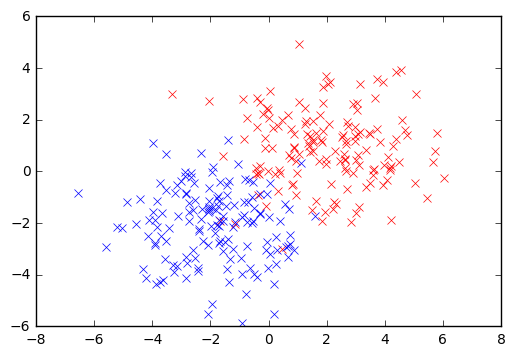

In [4]:
X, y = datasets(name='gaussian', n_points=300)
plot_dataset(X, y)

- The following function qp allows to solve a quadratic problem of the form:

$$
\left\{
  \begin{array}{cll}
  &\min_{(x)} \frac{1}{2}x^{\top} H x - e^\top x
  \\
   & \textrm{s.c.}\; A^\top x = b, 0 \leq x \leq C.
  \end{array}
  \right.
$$

In [5]:
import cvxopt


def qp(H, e, A, b, C=np.inf, l=1e-8, verbose=True):
    # Gram matrix
    n = H.shape[0]
    H = cvxopt.matrix(H)
    A = cvxopt.matrix(y, (1, n))
    e = cvxopt.matrix(-e)
    b = cvxopt.matrix(0.0)
    if C == np.inf:
        G = cvxopt.matrix(np.diag(np.ones(n) * -1))
        h = cvxopt.matrix(np.zeros(n))
    else:
        G = cvxopt.matrix(np.concatenate([np.diag(np.ones(n) * -1),
                                         np.diag(np.ones(n))], axis=0))
        h = cvxopt.matrix(np.concatenate([np.zeros(n), C * np.ones(n)]))

    # Solve QP problem
    cvxopt.solvers.options['show_progress'] = verbose
    solution = cvxopt.solvers.qp(H, e, G, h, A, b)
 
    # Lagrange multipliers
    mu = np.ravel(solution['x'])
    return mu

Definition of the linear kernel:

In [6]:
def kernel(X1, X2):
    n1 = X1.shape[0]
    n2 = X2.shape[0]
    K = np.empty((n1, n2))
    for i in range(n1):
        for j in range(n2):
            K[i, j] = np.dot(X1[i], X2[j])
    return K

### Questions

- Q4: Modify the following cell to solve the SVM dual problem:

Number of support vectors: 3


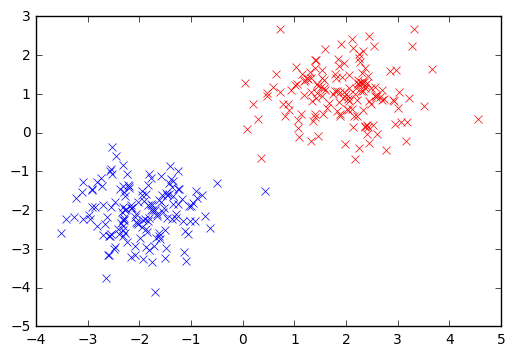

In [7]:
X, y = datasets(name='gaussian', n_points=300, sigma=0.7)
plot_dataset(X, y)

# TODO
def svm_solver(K, y, C=np.inf):
    y_mat = np.dot(y.reshape(1,-1).T,y.reshape(1,-1))
    H = np.multiply(y_mat,K)
    e = np.ones(K.shape[0])
    A = y
    b = 0
    mu = qp(H, e, A, b, C, l=1e-8, verbose=False)
    idx_support = np.where(np.abs(mu) > 1e-5)[0]
    mu_support = mu[idx_support]
    return mu_support, idx_support

K = kernel(X, X)

# Uncomment the following lines when your svm_solver is completed:
mu_support, idx_support = svm_solver(K, y)
print("Number of support vectors: %s" % idx_support.size)

- Q5: Compute w from mu and b

In [8]:
# TODO
w = np.sum((mu_support * y[idx_support]).reshape(1,-1).T * X[idx_support],axis=0)
print(w)

[ 0.93458491  2.46150328]


- Q6: Using complementary slackness, explain how to obtain $b$ from $\mu$.

HINT: Use the fact that for all support vectors for which $\mu_i$ is non-zero one has $y_{i}(w^{t}x_{i}+b) = 1$.

We use the K.K.T. condition of complementary slackness: 

Let us find $b$: 
$$
y_i(w^tx_i + b) = 1 \iff w^tx_i + b = y_i^{-1} \iff b = y_i - w^tx_i
$$ 

since $y_i \in \{-1,+1\}$.

We only need to use a support vector (i.e. a vector for which $\mu_i$ is non-zero).

In [9]:
# TODO

def compute_b(K, y, mu_support, idx_support):
    # TODO
    #We always choose the first support vector
    b = y[idx_support[0]] - np.sum(mu_support * y[idx_support] * [K[idx_support[0],j] for j in idx_support])
    return b

b = compute_b(K, y, mu_support, idx_support)

In [10]:
print(b)

2.27628079859


- Q7: Verify that the constraints of the primal problem are satistified up to an acceptable numerical precision. You should verify that for all $i$ we have:

$$
y_{i}(w^{\top}x_{i}+b) \geq 1 - \epsilon
$$

using for example $\epsilon = 1e-5$.

In [11]:
# TODO
def checkConstraint(y,w,X,b,epsilon=10**-5):
    listOfConstraints = [int(y[i]*(np.dot(w.T,X[i,:]) + b) < 1 - epsilon) for i in range(y.shape[0])]
    return np.sum(listOfConstraints)

In [12]:
print("There are " + str(checkConstraint(y,w,X,b)) + " samples that do not meet verify the primal constraint.")

There are 0 samples that do not meet verify the primal constraint.


Check your code by running the following cell:

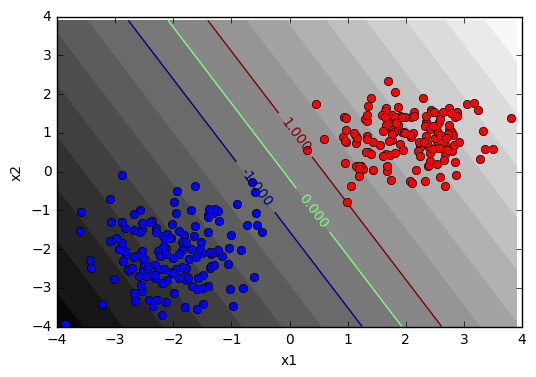

In [13]:
X, y = datasets(name='gaussian', n_points=300, sigma=0.7)

K = kernel(X, X)
mu_support, idx_support = svm_solver(K, y)
b = compute_b(K, y, mu_support, idx_support)

def plot_classif(X, y, mu_support, idx_support, b, kernel=kernel):
    # Calcul de la fonction de décision sur une grille
    X1, X2 = np.mgrid[-4:4:0.1, -4:4:0.1]
    na, nb = X1.shape
    X_test = np.c_[np.reshape(X1, (na * nb, 1)),
                   np.reshape(X2, (na * nb, 1))]

    # Calcul des produits scalaires
    X_support = X[idx_support]
    G = kernel(X_test, X_support)
    # Calcul de la fonction de décision
    decision = G.dot(mu_support * y[idx_support]) + b

    # Calcul du label prédit
    y_pred = np.sign(decision)

    # Affichage des lignes de niveau de la fonction de decision
    plt.contourf(X1, X2, np.reshape(decision, (na, nb)), 20, cmap=plt.cm.gray)
    cs = plt.contour(X1, X2, np.reshape(decision, (na,nb)), [-1, 0, 1], color='g', linewidth=2)
    plt.clabel(cs, inline=1)
    plt.plot(X[y == 1,0], X[y == 1, 1], 'or', linewidth=2)
    plt.plot(X[y == -1,0], X[y == -1, 1], 'ob', linewidth=2)
    plt.xlabel('x1')
    plt.ylabel('x2')
    plt.xlim([-4, 4])
    plt.ylim([-4, 4])

plot_classif(X, y, mu_support, idx_support, b)

We will now change the value of $\sigma$ such that the problem is not linearily separable anymore.

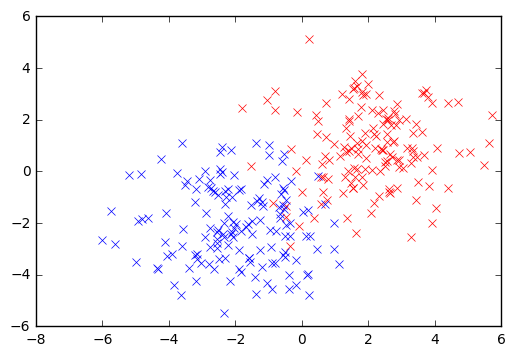

In [14]:
X, y = datasets(name='gaussian', n_points=300, sigma=1.5)
plot_dataset(X, y)

In [15]:
K = kernel(X, X)
mu_support, idx_support = svm_solver(K, y)
b = compute_b(K, y, mu_support, idx_support)
w = np.sum((mu_support * y[idx_support])[: , None] * X[idx_support], axis=0)

- Q8: Check that contraints of the problem are now violated.

In [16]:
# TODO
print("There are now " + str(checkConstraint(y,w,X,b)) + " samples that do not verify the primal constraint.")

There are now 252 samples that do not verify the primal constraint.


## Part 1: Non separable case with cvxopt

In practice it is very likely that the classes are not linearly separable.

A very natural idea is to relax the constraints $y_{i}(w^\top x_i + c) \geq 1$.
To do this, so called soft-margin SVM have been introduced using
so called slack variables: $\xi_{i}\geq 0$. The problem becomes:

$$
 y_{i}(w^\top x_i + b) \geq 1 - \xi_i, \; \xi_i \geq 0 \enspace .
$$

Note that if $\xi_i > 1$, the sample $x_{i}$ will be misclassified. To prevent
this case to be too frequent, an idea is to minimize the sum of the $\xi_{i}$.
This leads to the following problem:

$$
(P_{s}):  \left\{
 \begin{array}{ll}
 \min_{(w,b,\xi)} & \frac{1}{2}w^{\top}w + C \sum_i \xi_i
 \\
 \mathrm{s.t.} & y_{i}(w^{\top}x_{i}+b) \geq 1 - \xi_i\\
 \mathrm{and} & -\xi_i \leq 0
 \end{array}
 \right.
$$

The constant $C$ controls the regularisation.

### Questions

- Q9: Justify that $(P_{s})$ is a convex problem

We use the same argument as before:

The set of constraints is convex as a finite intersection of convex sets (themselves, convex as inverse transformations of a convex set by a linear function).

The function to be optimized is convex, as the sum of two convex functions.

- Show that a dual problem of $(P_{s})$ reads:

$$
(\mathcal{D}):
\left\{
\begin{array}{lll}
\min_{\mu} &\frac{1}{2}\mu^{\top}GG^{\top}\mu-\mu^{\top}u
\\
\mathrm{s.t.}& y^{\top}\mu = 0
\\
\mathrm{et}& 0 \leq \mu \leq C
\end{array}
\right .
$$

Like before, let us first rewrite our problem:

$$
(\mathcal{P}_s):  \left\{
 \begin{array}{cll}
 &\min_{(w,b,\xi)} \frac{1}{2}w^{\top}w + C^{\top}\xi
 \\
  &G . w + b . y \succeq u - \xi
 \\
  & \xi \succeq 0
 \end{array}
 \right.
$$

where $G$ and $u$ are given in the upper text. $C$ stands for a vector full of $C$ and $\xi$, for the vector of the $\xi_i$.

The Lagrangian of the problem reads:

$$
L(w, b, \xi,\mu,\alpha) = \frac{1}{2}w^{\top}w + C^{\top}\xi + \mu^{\top}(u - Gw - by - \xi) - \alpha^{\top}\xi
$$

We use the K.K.T. conditions to obtain the dual form.

We optimize the Lagrangian w.r.t. $w$ and get:

$$
w = G^{\top} \mu
$$

Then with $b$:

$$
\mu^{\top}y = y^{\top}\mu = 0
$$

And finally with $\xi$:

$$
C - \mu - \alpha = 0 \Rightarrow 0 \preceq \mu \preceq C
$$

because $\alpha$ and $\mu$ contain only strictly positive real numbers.


Hence, the dual problem can be written as: 

$$
(\mathcal{D}): 
 \left\{
 \begin{array}{lll}
 \max_{\mu} &\frac{1}{2}\mu^{\top}GG^{\top}\mu + C^{\top}\xi + \mu^{\top}u - \mu^{\top}GG^{\top}\mu - \mu^{\top}\xi - \alpha^{\top}\xi
 \\
 \mathrm{s.c.}& y^{\top}\mu = 0
 \\
 \mathrm{and}& 0 \preceq \mu \preceq C
 \end{array}
 \right .
$$

Which can be rewritten as: 

$$
(\mathcal{D}): 
 \left\{
 \begin{array}{lll}
 \min_{\mu} &\frac{1}{2}\mu^{\top}GG^{\top}\mu - \mu^{\top}u
 \\
 \mathrm{s.c.}& y^{\top}\mu = 0
 \\
 \mathrm{and}& 0 \preceq \mu \preceq C
 \end{array}
 \right .
$$
thanks to the following equality:

$$
C - \mu - \alpha = 0
$$

- Q10: Modify your code from Q4 to handle the non-separable case.

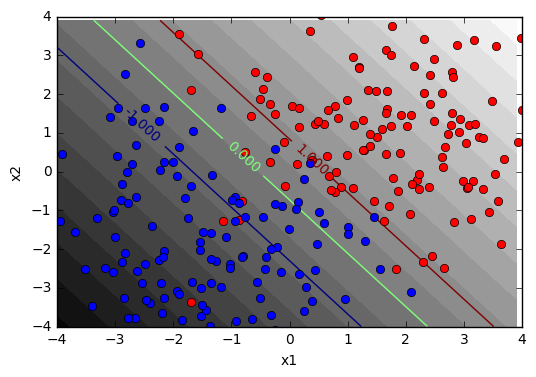

In [17]:
# TODO
X, y = datasets(name='gaussian', n_points=300, sigma=1.7)

K = kernel(X, X)
mu_support, idx_support = svm_solver(K,y,C=.1)
b = compute_b(K, y, mu_support, idx_support)

plot_classif(X, y, mu_support, idx_support, b)

In [18]:
listOfC = [.1,.2,.5,.8,1.,1.5,2.,4.,6.,10., 20., 50., 100.]
number = []
for l in listOfC:
    mu_support, idx_support = svm_solver(K,y,C=l)
    number.append(len(idx_support))
    print 'C: ', l, '| Number of Support Vectors: ', len(idx_support)

C:  0.1 | Number of Support Vectors:  54
C:  0.2 | Number of Support Vectors:  48
C:  0.5 | Number of Support Vectors:  45
C:  0.8 | Number of Support Vectors:  43
C:  1.0 | Number of Support Vectors:  43
C:  1.5 | Number of Support Vectors:  43
C:  2.0 | Number of Support Vectors:  42
C:  4.0 | Number of Support Vectors:  41
C:  6.0 | Number of Support Vectors:  41
C:  10.0 | Number of Support Vectors:  41
C:  20.0 | Number of Support Vectors:  42
C:  50.0 | Number of Support Vectors:  41
C:  100.0 | Number of Support Vectors:  42


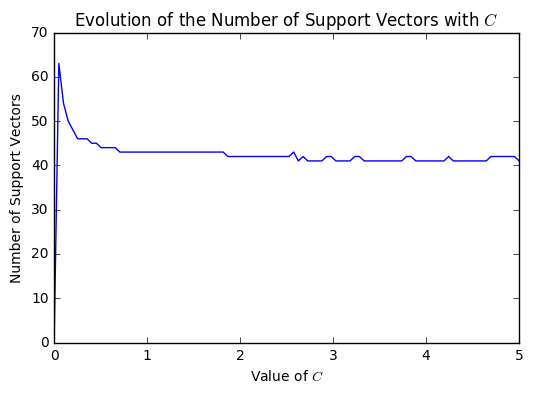

In [19]:
listOfC = np.linspace(0, 5, 100)
number = []
for l in listOfC:
    mu_support, idx_support = svm_solver(K,y,C=l)
    number.append(len(idx_support))
    
plt.figure()
plt.plot(listOfC, number)
plt.xlabel('Value of $C$')
plt.ylabel('Number of Support Vectors')
plt.title('Evolution of the Number of Support Vectors with $C$')
plt.show()

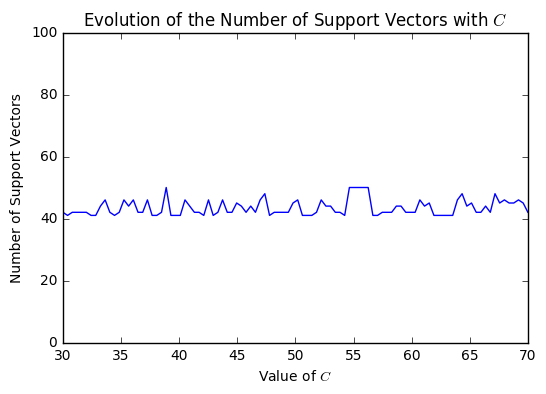

In [20]:
listOfC = np.linspace(30, 70, 100)
number = []
for l in listOfC:
    mu_support, idx_support = svm_solver(K,y,C=l)
    number.append(len(idx_support))
    
plt.figure()
plt.plot(listOfC, number)
plt.ylim([0, 100])
plt.xlabel('Value of $C$')
plt.ylabel('Number of Support Vectors')
plt.title('Evolution of the Number of Support Vectors with $C$')
plt.show()

- Q11: What is the influence of C on the number of support vectors? Justify this from an optimization stand point.

We see from the previous graph that, from $0$ to around $0.8$ for $C$ values, the number of support vectors decreases, until reaching a level of 54. However, when we take a closer look at the number of support vectors for greater values of C (greater than $30$), we observe that this number can vary and present spikes.

When we use a greater C, this means that we give a greater weight to the regularization induced by the slack variables. Hence, the margin between the extremal separating hyperplanes defined by:

$$
w^{\top} x + b = \pm 1
$$

will decrease.

Let us explain what is going on here.
When we increase the parameter $C$, this means that we give a greater strength to the regularization, and that we impose the $\xi_i$ to be smaller. Each $\xi_i$ allows the corresponding observation to be on the other side of its associated extremal separating hyperplane. The greater the $\xi_i$, the larger the distance between the observation and its extremal hyperplane. Therefore, the smaller the $\xi_i$, the smaller the distance between the two extremal hyperplanes and the outliers. Therefore, the margin will decrease and the number of support vectors, defined as: 

$$
w^{\top} x_i + b = \pm (1 - \xi_i)
$$

with $\xi_i \geq 0$, will be smaller.

## Part 2: non-linear case with kernels

Another scenario is when the boundary between classes is not linear.

To cope with this the idea is to use kernels.

- Q12: Denoting by $K(x_i, x_j)$ the dot product between samples show that dual problem and the decision function $f(x)$ can be reformulated just using calls to $K$

We can reformulate the dual problem as follows:

$$
(\mathcal{D}):
\left\{
\begin{array}{lll}
\min_{\mu} &\frac{1}{2}\mu^{\top}yy^{\top} \odot K\mu-\mu^{\top}u
\\
\mathrm{s.t.}& y^{\top}\mu = 0
\\
\mathrm{et}& 0 \leq \mu \leq C
\end{array}
\right .
$$

And the decision function:

$$y = sign(w^{\top}x + b) = sign \left(\sum_{i=1}^{n} \mu_i y_i K(x_i,x) + b \right)$$

We will use the clowns dataset to evaluate this:

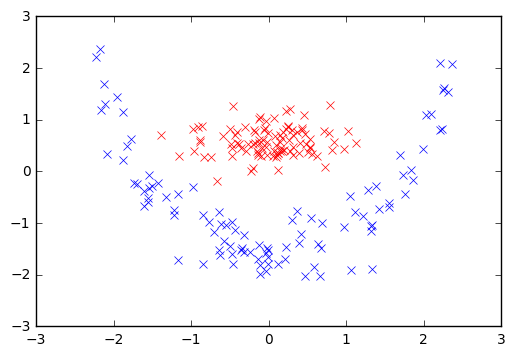

In [21]:
X, y = datasets(name='clowns', n_points=200, sigma=0.7)

plot_dataset(X, y)

- Q13: Update your kernel function so it computes the Gaussian kernel:

$$
    K(x_i, x_j) = \exp(-\gamma \| x_i - x_j \|)
$$

where $\gamma > 0$ is the kernel bandwidth.

In [22]:
# TODO

from scipy import linalg

def rbf_kernel(X1, X2, gamma = 3.):
    n1 = X1.shape[0]
    n2 = X2.shape[0]
    K = np.empty((n1, n2))
    
    for i in range(n1):
        for j in range(n2):
            K[i, j] = np.exp(-gamma*np.linalg.norm(X1[i] - X2[j])*2)  # CHANGE THIS
    return K

Using the change above the follwing code should allow you to nicely separate the red from the blue dots

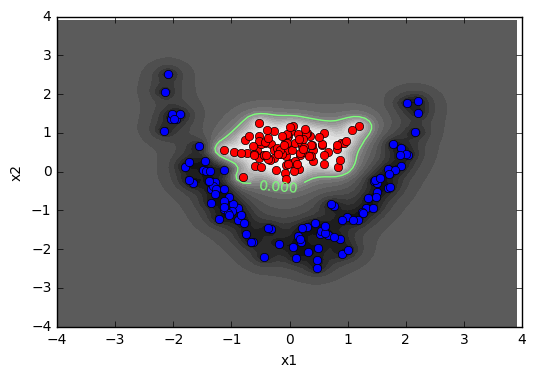

In [23]:
X, y = datasets(name='clowns', n_points=200, sigma=0.7)

K = rbf_kernel(X, X)
mu_support, idx_support = svm_solver(K, y, C=1.)
b = compute_b(K, y, mu_support, idx_support)

plot_classif(X, y, mu_support, idx_support, b, kernel=rbf_kernel)

## Part 3: Linear SVM without intercept

The problem of the formuation of SVMs with the intercept term $b$ is that
it leads to an annoying constraint in the dual, namely the $y^{t}\mu = 0$.

We will now see what we can do about it.

Let's consider the problem

$$
(P'_{s}):  \left\{
 \begin{array}{ll}
 \min_{(w,\xi)} & \frac{1}{2}w^{\top}w + C \sum_i \xi_i
 \\
 \mathrm{s.t.} & y_{i}(w^{\top}x_{i}) \geq 1 - \xi_i\\
 \mathrm{and} & -\xi_i \leq 0
 \end{array}
 \right.
$$

- Q14: Show that a dual problem of $(P'_{s})$ is given by:

$$
(\mathcal{D}):
\left\{
\begin{array}{lll}
\min_{\mu} &\frac{1}{2}\mu^{\top}GG^{\top}\mu-\mu^{\top} 1_n
\\
\mathrm{s.t.}& 0 \leq \mu \leq C
\end{array}
\right .
$$

The same proof we used before works here, and since we do not consider the intercept term $b$, we do not need to optimize it when dealing with the Lagrangian. Hence, the constraint $y^t\mu$ is no more present in the problem.

- Q15: Rewrite the dual in the form:


$$
(\mathcal{D}): \min_{\mu} f(\mu) + g(\mu) .
$$

where $f$ is here a smooth function of $\mu$ with L-Liptschitz gradient and $g$ is a non-smooth function that is separable, namely:

$$
g(\mu) = \sum_{i=1}^n g_i(\mu_i)
$$

We can rewrite the dual in the form:

$$
(\mathcal{D}): \min_{\mu} f(\mu) + g(\mu) .
$$

with $f(\mu) = \frac{1}{2}\mu^{\top} G G^{\top} \mu - \mu^{\top}\mathbb{1}_n$ and $g(\mu)=\mathbb{1}_\mathcal{C}(\mu)$ with $\mathbb{1}_\mathcal{C}$ being the indicator function on $\mathcal{C} = [0 , C]^n$.

$g$ is separable, and each $g_i$ is the same indicator function, but on $\mathbb{R}$ and not $\mathbb{R}^n$. $g$ is non-smooth because it is not continuously differentiable.

$f$ is continuously differentiable and $\nabla f(\mu) = GG^{\top}\mu - \mathbb{1}_n$ because $GG^{\top}$ is symmetric.

$$
\forall x, y \in \mathbb{R}^n, \: ||\nabla f(x)-\nabla f(y)|| = ||GG^{\top}x - GG^{\top}y|| = ||GG^{\top}(x-y)|| \leq |||GG^{\top}|||.||x-y||
$$ 

Therefore, $f$ is   $|||GG^{\top}|||$-smooth.

The dual in the later form can be readily optimized using the methods that you have been studying in this class:

- Proximal gradient method with and without acceleration
- L-BFGS-B
- Coordinate descent

- Q16: Implement:

   - your own version of proximal gradient with and without acceleration
   - your own version of coordinate descent
   - an L-BFGS-B solver using `scipy.optimize.fmin_l_bfgs_b`

Note: We restrict ourselves to linear kernel here.

Note: To handle separating hyperplanes which do not pass through zero (due to absence of intercept)
you will add a column of ones to X. You can use something like this:

`X = np.concatenate((X, np.ones((len(X), 1))), axis=1)`

You will test your implementations on the Gaussian blobs and evaluate the performance of your implementations in terms of computation time on problems where the matrix $G G^\top$ can fit in memory.

You should reuse as much as possible the convergence evaluation code that you used during the labs.

For a coordinate descent method to be fast you need to have smart updates. You're expected to
come up with these smart updates in the problem at hand.

BONUS : With a smart implementation of the coordinate descent you should be able to scale the optimization to tens of thousands of samples ie cases where $G G^\top$ does not fit in memory anymore.

**IMPORTANT : This question Q16 is the most important and will constitute half of the final grade on the project !**

First, we simulate some overlapped gaussian data:

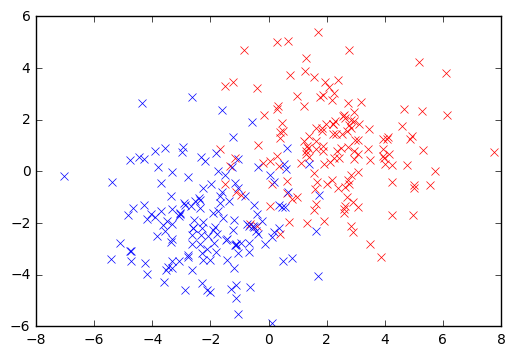

In [24]:
X, y = datasets(name='gaussian', n_points=300, sigma=1.7)
plot_dataset(X, y)

Here, since we do not work with an intercept $b$, we will add a column of ones to $X$.
We also compute some useful objects for the following.

In [25]:
X = np.concatenate((X, np.ones((len(X), 1))), axis=1)
K = kernel(X, X)
y_mat = y.reshape((-1, 1)).dot(y.reshape((1, -1))) ## This is yy^t
mat = np.multiply(y_mat, K) ## This is GG^t
C = 0.01 # We fix a value for C
n = X.shape[0]

In [26]:
#Some useful functions for what follows
from numpy.linalg import norm
from scipy.optimize import fmin_l_bfgs_b
import time

def prox_svm(mu,C):
    """Proximal operator for the SVM without intercept"""
    if np.size(mu) == 1:
        if mu  < 0:
            res = 0.
        elif mu > C:
            res = C
        else:
            res = mu
    else:
        res = mu.copy()
        temp1=np.where(res < 0)
        temp2=np.where(res > C)
        res[temp1]=0. 
        res[temp2]=C
    return res

def svm_penalization(mu,C=.1):
    """Computes the value of the SVM penalization (indicator function of [0,C])"""
    if (min(mu) < 0) | (max(mu) > C):
        result= np.inf
    else:
        result=0.
    return result

def loss_svm(mu):
    """First function of the dual (f)"""
    result=0.5*np.dot(mu.T,np.dot(mat,mu)) - np.sum(mu)
    return result

def grad_svm(mu):
    """Gradient of f"""
    result=np.dot(mat,mu.T)-np.ones(mu.shape[0])
    return result

def grad_svm_i(mu, i):
    """Gradient of f_i"""
    aux = mat[i, :]
    result=np.dot(aux,mu)-1
    return result

def lipschitz_svm(A):
    """Computes the Lipschitz constant of f (the highest eigenvalue of K works)"""
    L=norm(A, 2)
    return L

def total_loss(mu, C = 0.1):
    result = loss_svm(mu) + svm_penalization(mu, C = 0.1)
    return result

Let us first check the implementation of the gradients.

In [27]:
from scipy.optimize import check_grad

check_grad(loss_svm, grad_svm, np.random.randn(300))

0.0014480696452813314

Let us compute a precise minimizer for the cost function, using a L-BFGS optimizer from scipy.

In [28]:
from numpy.random import randn
mu0=np.zeros(n).astype(float)
mu_bfgs, f_min, dico = fmin_l_bfgs_b(total_loss, mu0, grad_svm, maxiter=10000, bounds=[(0, C) for i in range(mu0.shape[0])])
print 'The minimum is: ', f_min

The minimum is:  -0.777872311849


## ISTA

Here, we reuse the code we had implemented in previous labs.

In [29]:
from numpy.random import randn
def ista(mu0, f, grad_f, g, prox_g, step,mu_true, C=.1, n_iter=500,verbose=True):

    """Proximal gradient descent algorithm
    """
    mu = mu0.copy()

    # estimation error history
    errors = []
    # objective history
    objectives = []
    # Current estimation error
    err = norm(mu - mu_true) / norm(mu_true)
    errors.append(err)
    # Current objective
    obj = f(mu) + g(mu,C)
    objectives.append(obj)
    # Distance to final objective
    dist = [norm((obj - f_min)/f_min)]
    if verbose:
        print("Lauching ISTA solver...")
        print(' | '.join([name.center(8) for name in ["it", "obj", "err"]]))
      
    # Current time
    start = time.time()
    times = [0]
    for k in range(n_iter + 1):
                
        mu = prox_g(mu - step*grad_f(mu), C)
        obj = f(mu) + g(mu,C)
        err = norm(mu - mu_true) / norm(mu_true)
        errors.append(err)
        objectives.append(obj)
        dist.append(norm((obj - f_min)/f_min))
        times.append(time.time() - start)
        if k % 1000 == 0 and verbose:
             print(' | '.join([("%d" % k).rjust(8), 
                               ("%.2e" % obj).rjust(8), 
                               ("%.2e" % err).rjust(8)]))
    return mu, objectives, errors, times, dist

In [30]:
L=float(lipschitz_svm(mat))
mu_ista, obj_ista,err_ista, tim_ista, dist_ista=ista(mu0,loss_svm,grad_svm,svm_penalization,prox_svm,1./L,n_iter=30000,C=C,mu_true=mu_bfgs,verbose=True)

Lauching ISTA solver...
   it    |   obj    |   err   
       0 | -7.13e-02 | 9.65e-01
    1000 | -7.78e-01 | 4.08e-02
    2000 | -7.78e-01 | 1.74e-02
    3000 | -7.78e-01 | 8.32e-03
    4000 | -7.78e-01 | 4.04e-03
    5000 | -7.78e-01 | 1.97e-03
    6000 | -7.78e-01 | 9.66e-04
    7000 | -7.78e-01 | 4.79e-04
    8000 | -7.78e-01 | 2.42e-04
    9000 | -7.78e-01 | 1.27e-04
   10000 | -7.78e-01 | 7.21e-05
   11000 | -7.78e-01 | 4.58e-05
   12000 | -7.78e-01 | 3.34e-05
   13000 | -7.78e-01 | 2.77e-05
   14000 | -7.78e-01 | 2.50e-05
   15000 | -7.78e-01 | 2.37e-05
   16000 | -7.78e-01 | 2.31e-05
   17000 | -7.78e-01 | 2.28e-05
   18000 | -7.78e-01 | 2.27e-05
   19000 | -7.78e-01 | 2.26e-05
   20000 | -7.78e-01 | 2.26e-05
   21000 | -7.78e-01 | 2.26e-05
   22000 | -7.78e-01 | 2.26e-05
   23000 | -7.78e-01 | 2.26e-05
   24000 | -7.78e-01 | 2.26e-05
   25000 | -7.78e-01 | 2.26e-05
   26000 | -7.78e-01 | 2.26e-05
   27000 | -7.78e-01 | 2.26e-05
   28000 | -7.78e-01 | 2.26e-05
   29000 | -7.78e

We plot the evolution of ther error w.r.t. the number of iterations first, then w.r.t. the computation time, with a log scale.

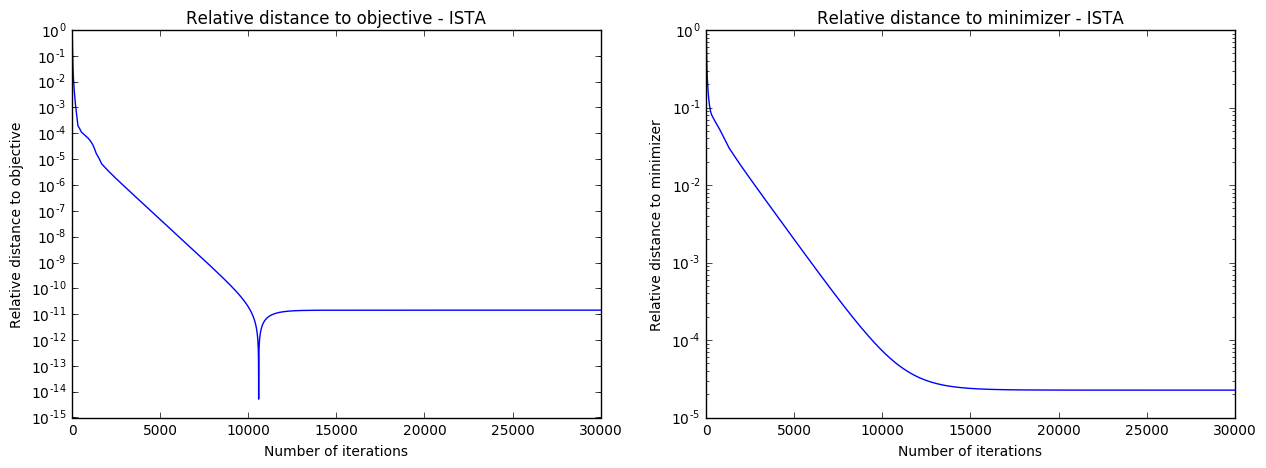

In [31]:
plt.figure(figsize=(15, 5))

plt.subplot(1, 2, 1)


plt.plot(dist_ista)
plt.yscale("log")
plt.title("Relative distance to objective - ISTA")
plt.xlabel("Number of iterations")
plt.ylabel("Relative distance to objective")
plt.xlim([0, 30000])


plt.subplot(1, 2, 2)

plt.plot(err_ista)
plt.yscale("log")
plt.title("Relative distance to minimizer - ISTA")
plt.xlabel("Number of iterations")
plt.ylabel("Relative distance to minimizer")
plt.xlim([0, 30000])
plt.show()

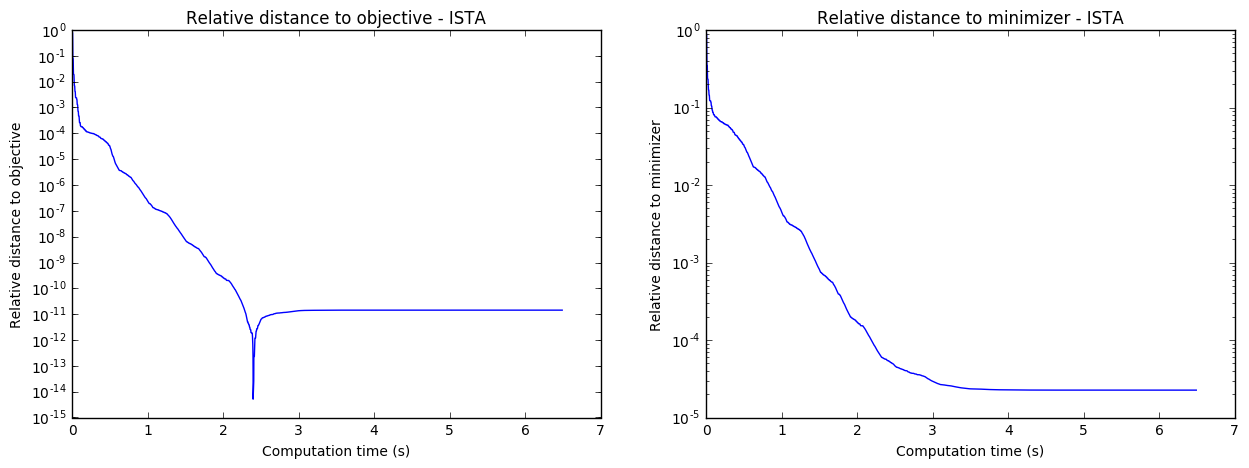

In [32]:
plt.figure(figsize=(15, 5))

plt.subplot(1, 2, 1)


plt.plot(tim_ista, dist_ista)
plt.yscale("log")
plt.title("Relative distance to objective - ISTA")
plt.xlabel("Computation time (s)")
plt.ylabel("Relative distance to objective")


plt.subplot(1, 2, 2)

plt.plot(tim_ista, err_ista)
plt.yscale("log")
plt.title("Relative distance to minimizer - ISTA")
plt.xlabel("Computation time (s)")
plt.ylabel("Relative distance to minimizer")
plt.show()

We then compute the value of $w$ for ISTA, in order the plot the classification result.

In [33]:
idx_support_ista = np.where(np.abs(mu_ista) > 1e-5)[0]
mu_support_ista = mu_ista[idx_support_ista]
w_ista = np.sum((mu_support_ista * y[idx_support_ista]).reshape(1,-1).T * X[idx_support_ista],axis=0)

In [34]:
def plot_classif2(X, y, mu_support, idx_support, b, kernel=kernel):
    # Calcul de la fonction de décision sur une grille
    X1, X2 = np.mgrid[-4:4:0.1, -4:4:0.1]
    na, nb = X1.shape
    X_test = np.c_[np.reshape(X1, (na * nb, 1)),
                   np.reshape(X2, (na * nb, 1))]

    # Calcul des produits scalaires
    X_support = X[idx_support,:2]
    G = kernel(X_test, X_support)
    # Calcul de la fonction de décision
    decision = G.dot(mu_support * y[idx_support]) + b

    # Calcul du label prédit
    y_pred = np.sign(decision)

    # Affichage des lignes de niveau de la fonction de decision
    plt.contourf(X1, X2, np.reshape(decision, (na, nb)), 20, cmap=plt.cm.gray)
    cs = plt.contour(X1, X2, np.reshape(decision, (na,nb)), [-1, 0, 1], color='g', linewidth=2)
    plt.clabel(cs, inline=1)
    plt.plot(X[y == 1,0], X[y == 1, 1], 'or', linewidth=2)
    plt.plot(X[y == -1,0], X[y == -1, 1], 'ob', linewidth=2)
    plt.xlabel('x1')
    plt.ylabel('x2')
    plt.xlim([-4, 4])
    plt.ylim([-4, 4])

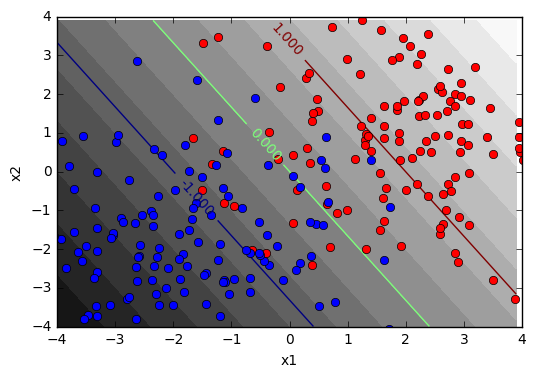

In [35]:
plot_classif2(X, y, mu_support_ista, idx_support_ista, b=0)

## Accelerated proximal gradient (aka FISTA)

In [36]:
def fista(mu0, f, grad_f, g, prox_g, step, mu_true,C=.1, n_iter=3000,verbose=True):
    """Accelerated Proximal gradient descent algorithm
    """
    mu = mu0.copy()
    mu_new = mu0.copy()
    # An extra variable is required for FISTA
    z = mu0.copy()   
    
    # estimation error history
    errors = []
    # objective history
    objectives = []
    # Current estimation error
    err = norm(mu - mu_true) / norm(mu_true)
    errors.append(err)
    # Current objective
    obj = f(mu) + g(mu, C)
    objectives.append(obj)
    # Distance to final objective
    dist = [norm((obj - f_min)/f_min)]
    
    t = 1.
    
    if verbose:
        print("Lauching FISTA solver...")
        print(' | '.join([name.center(8) for name in ["it", "obj", "err"]]))
        
    times = [0]
    start = time.time()
    
    for k in range(n_iter + 1):
        
        mu_new = prox_g(z - step*grad_f(z), C)
        t_new = (1 + np.sqrt(1 + 4*(t**2)))/2
        z_new = mu_new + ((t-1)/t_new)*(mu_new - mu)
        
        mu = mu_new
        t = t_new
        z = z_new
        
        obj = f(mu) + g(mu, C)
        err = norm(mu - mu_true) / norm(mu_true)
        errors.append(err)
        objectives.append(obj)
        dist.append(norm((obj - f_min)/f_min))
        times.append(time.time() - start)
        
        if k % 1000 == 0 and verbose:
            print(' | '.join([("%d" % k).rjust(8), 
                              ("%.2e" % obj).rjust(8), 
                              ("%.2e" % err).rjust(8)]))
            
    return mu, objectives, errors, times, dist

In [37]:
mu_fista, obj_fista, err_fista, tim_fista, dist_fista=fista(mu0,loss_svm,grad_svm,svm_penalization,prox_svm,1./L,n_iter=30000,C=C,mu_true=mu_bfgs,verbose=True)

Lauching FISTA solver...
   it    |   obj    |   err   
       0 | -7.13e-02 | 9.65e-01
    1000 | -7.78e-01 | 3.37e-04
    2000 | -7.78e-01 | 1.20e-04
    3000 | -7.78e-01 | 2.38e-05
    4000 | -7.78e-01 | 1.51e-05
    5000 | -7.78e-01 | 3.23e-05
    6000 | -7.78e-01 | 2.32e-05
    7000 | -7.78e-01 | 1.99e-05
    8000 | -7.78e-01 | 2.29e-05
    9000 | -7.78e-01 | 2.34e-05
   10000 | -7.78e-01 | 2.22e-05
   11000 | -7.78e-01 | 2.23e-05
   12000 | -7.78e-01 | 2.27e-05
   13000 | -7.78e-01 | 2.26e-05
   14000 | -7.78e-01 | 2.25e-05
   15000 | -7.78e-01 | 2.25e-05
   16000 | -7.78e-01 | 2.26e-05
   17000 | -7.78e-01 | 2.25e-05
   18000 | -7.78e-01 | 2.25e-05
   19000 | -7.78e-01 | 2.26e-05
   20000 | -7.78e-01 | 2.26e-05
   21000 | -7.78e-01 | 2.25e-05
   22000 | -7.78e-01 | 2.26e-05
   23000 | -7.78e-01 | 2.26e-05
   24000 | -7.78e-01 | 2.26e-05
   25000 | -7.78e-01 | 2.26e-05
   26000 | -7.78e-01 | 2.26e-05
   27000 | -7.78e-01 | 2.26e-05
   28000 | -7.78e-01 | 2.26e-05
   29000 | -7.78

We plot the evolution of ther error w.r.t. the number of iterations first, then w.r.t. the computation time, with a log scale.

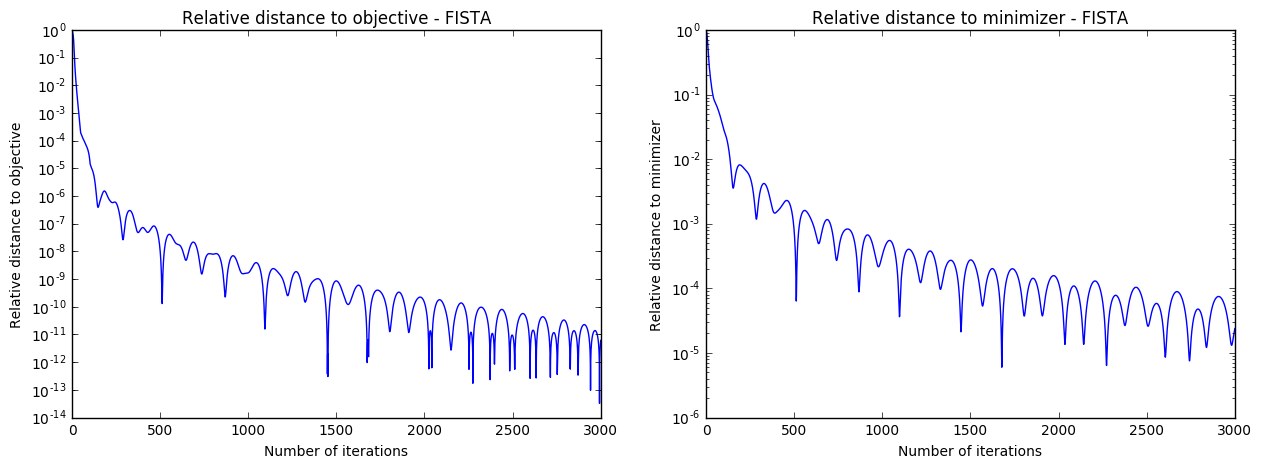

In [38]:
plt.figure(figsize=(15, 5))

plt.subplot(1, 2, 1)


plt.plot(dist_fista)
plt.yscale("log")
plt.title("Relative distance to objective - FISTA")
plt.xlabel("Number of iterations")
plt.ylabel("Relative distance to objective")
plt.xlim([0, 3000])


plt.subplot(1, 2, 2)

plt.plot(err_fista)
plt.yscale("log")
plt.title("Relative distance to minimizer - FISTA")
plt.xlabel("Number of iterations")
plt.ylabel("Relative distance to minimizer")
plt.xlim([0, 3000])
plt.show()

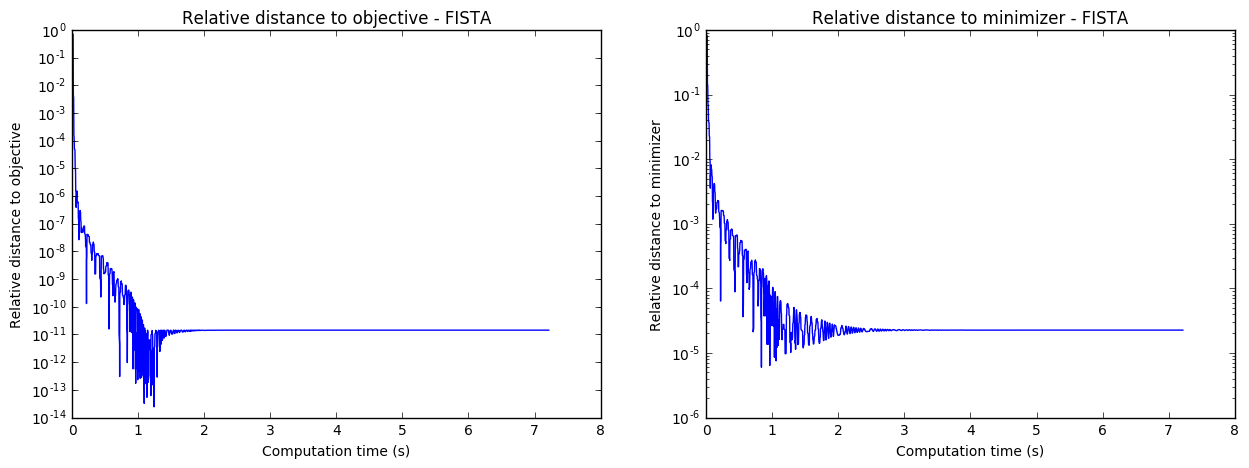

In [39]:
plt.figure(figsize=(15, 5))

plt.subplot(1, 2, 1)


plt.plot(tim_fista, dist_fista)
plt.yscale("log")
plt.title("Relative distance to objective - FISTA")
plt.xlabel("Computation time (s)")
plt.ylabel("Relative distance to objective")


plt.subplot(1, 2, 2)

plt.plot(tim_fista, err_fista)
plt.yscale("log")
plt.title("Relative distance to minimizer - FISTA")
plt.xlabel("Computation time (s)")
plt.ylabel("Relative distance to minimizer")
plt.show()

We then compute the value of $w$ for FISTA, in order the plot the classification result.

In [40]:
idx_support_fista = np.where(np.abs(mu_fista) > 1e-5)[0]
mu_support_fista = mu_fista[idx_support_fista]
w_fista = np.sum((mu_support_fista * y[idx_support_fista]).reshape(1,-1).T * X[idx_support_fista],axis=0)

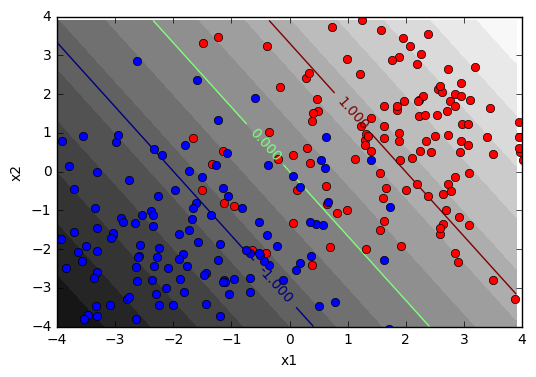

In [41]:
plot_classif2(X, y, mu_support_fista, idx_support_fista, b=0)

As we saw in the previous labs, ISTA and FISTA converge approximately with the same precision, but FISTA converges way faster than ISTA, both in terms of number of iterations and of computation time.
As expected, FISTA is not a descent algorithm.

## Coordinate gradient descent

In [57]:
def cd_optim(mu0, f, grad_f, g, prox_g,mu_true, C=.1, n_iter=500,verbose=True):
    mu = mu0.copy()
    mu_new = mu0.copy()
    
    # estimation error history
    errors = []
    # objective history
    objectives = []
    # Current estimation error
    err = norm(mu - mu_true) / norm(mu_true)
    errors.append(err)
    # Current objective
    obj = f(mu) + g(mu,C)
    objectives.append(obj)
    # Distance to final objective
    dist = [norm((obj - f_min)/f_min)]    
    
    L_temp=[mat[i, i] for i in range(300)]
    
    mu_new[0] = prox_g(mu_new[0] - (1./L_temp[0])*grad_f(mu_new, 0), C)
    
    times = [0]
    start = time.time()
    for k in range(1,n_iter + 1):
        i = k % len(y)
        
        mu = mu_new.copy()
        
        mu_new[i] = prox_g(mu_new[i] - (1./L_temp[i])*grad_f(mu_new, i), C)
        
        obj = f(mu_new) + g(mu_new, C)
        err = norm(mu_new - mu_true) / norm(mu_true)
        errors.append(err)
        objectives.append(obj)
        dist.append(norm((obj - f_min)/f_min))
        times.append(time.time() - start)
        
    return mu_new, objectives, errors, times, dist

In [58]:
mu_cd, obj_cd, err_cd, tim_cd, dist_cd=cd_optim(mu0,loss_svm, grad_svm_i,svm_penalization,prox_svm,n_iter=30000,mu_true=mu_bfgs, C = C,verbose=True)

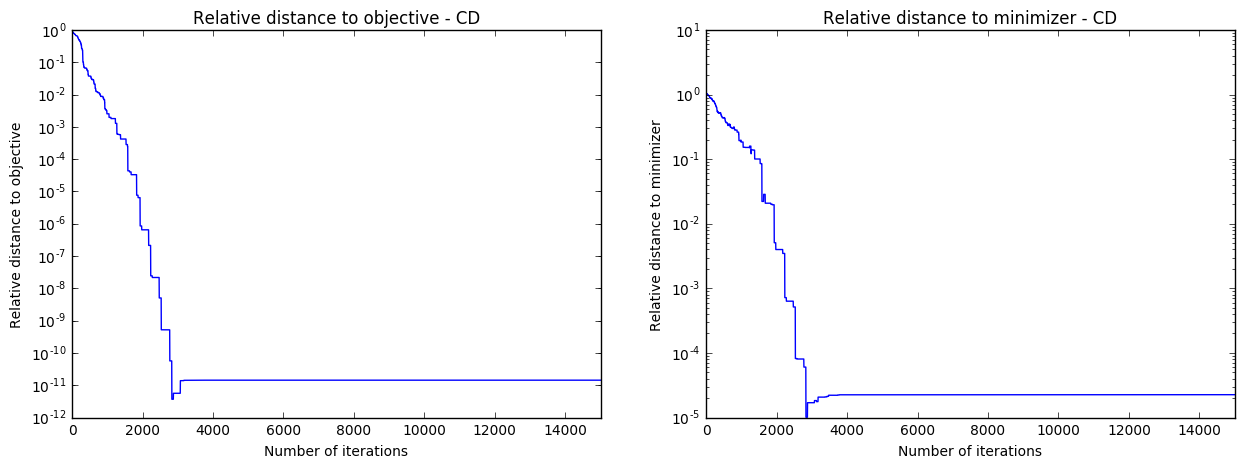

In [59]:
plt.figure(figsize=(15, 5))

plt.subplot(1, 2, 1)


plt.plot(dist_cd)
plt.yscale("log")
plt.title("Relative distance to objective - CD")
plt.xlabel("Number of iterations")
plt.ylabel("Relative distance to objective")
plt.xlim([0, 15000])


plt.subplot(1, 2, 2)

plt.plot(err_cd)
plt.yscale("log")
plt.title("Relative distance to minimizer - CD")
plt.xlabel("Number of iterations")
plt.ylabel("Relative distance to minimizer")
plt.xlim([0, 15000])
plt.show()

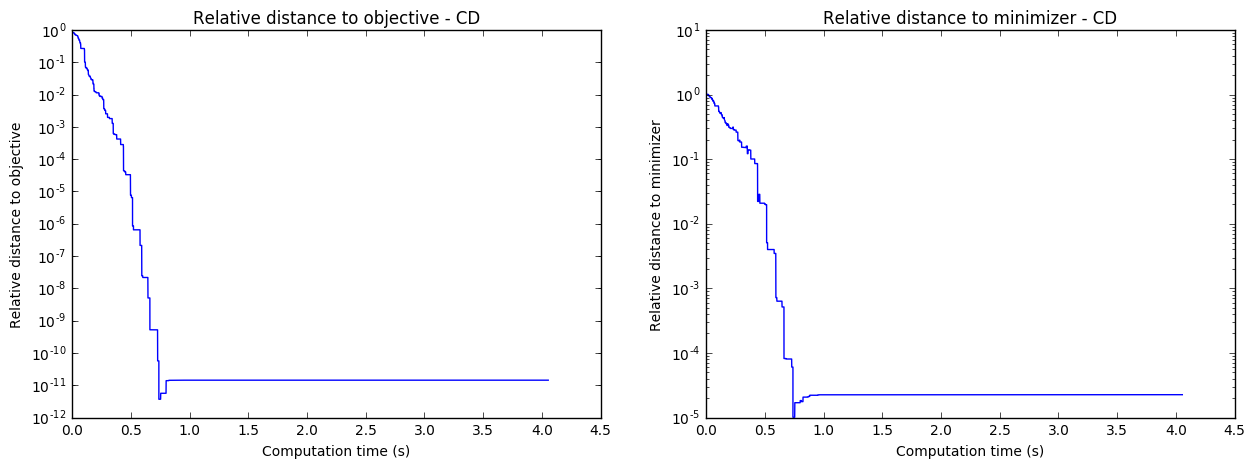

In [60]:
plt.figure(figsize=(15, 5))

plt.subplot(1, 2, 1)


plt.plot(tim_cd, dist_cd)
plt.yscale("log")
plt.title("Relative distance to objective - CD")
plt.xlabel("Computation time (s)")
plt.ylabel("Relative distance to objective")


plt.subplot(1, 2, 2)

plt.plot(tim_cd, err_cd)
plt.yscale("log")
plt.title("Relative distance to minimizer - CD")
plt.xlabel("Computation time (s)")
plt.ylabel("Relative distance to minimizer")
plt.show()

Let us implement a coordinate descent with smart updates.
Here, we minimize the computation time to update the gradient w.r.t. the $i$-th coordinate, by using the fact that only one coordinate of $\mu$ changes at each iteration.

At each iteration, we remove the old $\mu_i$ (multiplied by the elements of $(GG^t)_i$), and add the new elements, corresponding to the $i$-th coordinate, in order to update the gradient.

In [69]:
def cd_optim_smart(mu0, f, grad_f, g, prox_g, mu_true, C=.01, n_iter=500,verbose=True):
    mu = mu0.copy()
    mu_new = mu0.copy()
    
    # estimation error history
    errors = []
    # objective history
    objectives = []
    # Current estimation error
    err = norm(mu - mu_true) / norm(mu_true)
    errors.append(err)
    # Current objective
    obj = f(mu) + g(mu,C)
    objectives.append(obj)
    # Distance to final objective
    dist = [norm((obj - f_min)/f_min)]    
    
    L_temp=[mat[i, i] for i in range(300)]
    
    mu_new[0] = prox_g(mu_new[0] - (1./L_temp[0])*grad_svm_i(mu_new, 0), C)
    update_grad=grad_svm(mu_new)
    mu[0]=mu_new[0]
    
    times = [0]
    start = time.time()
    for k in range(1,n_iter + 1):
        i = k % len(y)

        
        mu_new[i] = prox_g(mu_new[i] - (1./L_temp[i])*update_grad[i], C)
        aux = mat[i,:]*(mu_new[i]-mu[i])
        update_grad = update_grad + aux
        
        obj = f(mu_new) + g(mu_new, C)
        err = norm(mu_new - mu_true) / norm(mu_true)
        errors.append(err)
        objectives.append(obj)
        dist.append(norm((obj - f_min)/f_min))
        times.append(time.time() - start)
        
        mu[i]=mu_new[i]
        
    return mu_new, objectives, errors, times, dist

In [70]:
mu_smart, obj_smart, err_smart, tim_smart, dist_smart=cd_optim_smart(mu0,loss_svm, grad_svm_i,svm_penalization,prox_svm,n_iter=10000,mu_true=mu_bfgs, C = C,verbose=True)

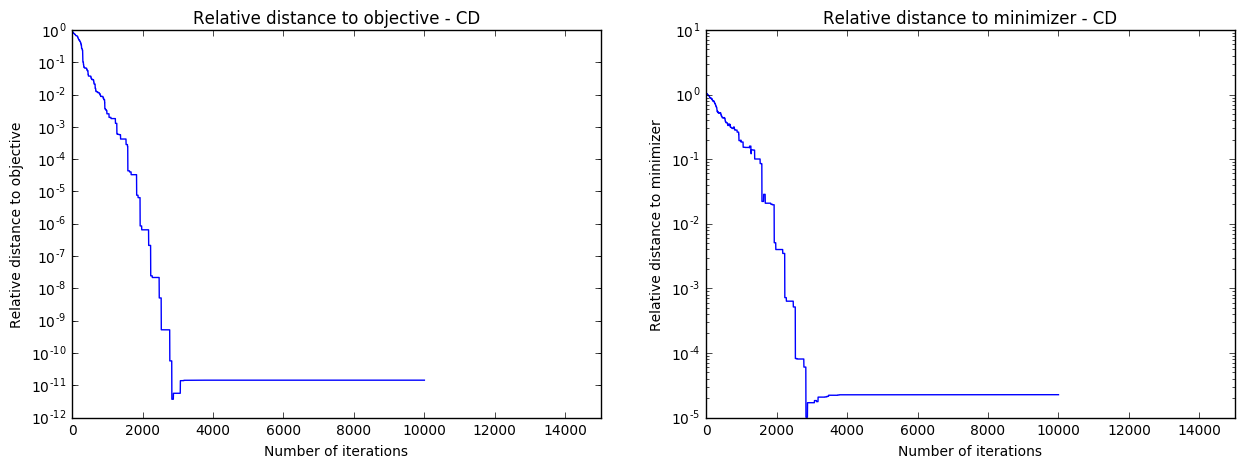

In [71]:
plt.figure(figsize=(15, 5))

plt.subplot(1, 2, 1)


plt.plot(dist_smart)
plt.yscale("log")
plt.title("Relative distance to objective - CD")
plt.xlabel("Number of iterations")
plt.ylabel("Relative distance to objective")
plt.xlim([0, 15000])


plt.subplot(1, 2, 2)

plt.plot(err_smart)
plt.yscale("log")
plt.title("Relative distance to minimizer - CD")
plt.xlabel("Number of iterations")
plt.ylabel("Relative distance to minimizer")
plt.xlim([0, 15000])
plt.show()

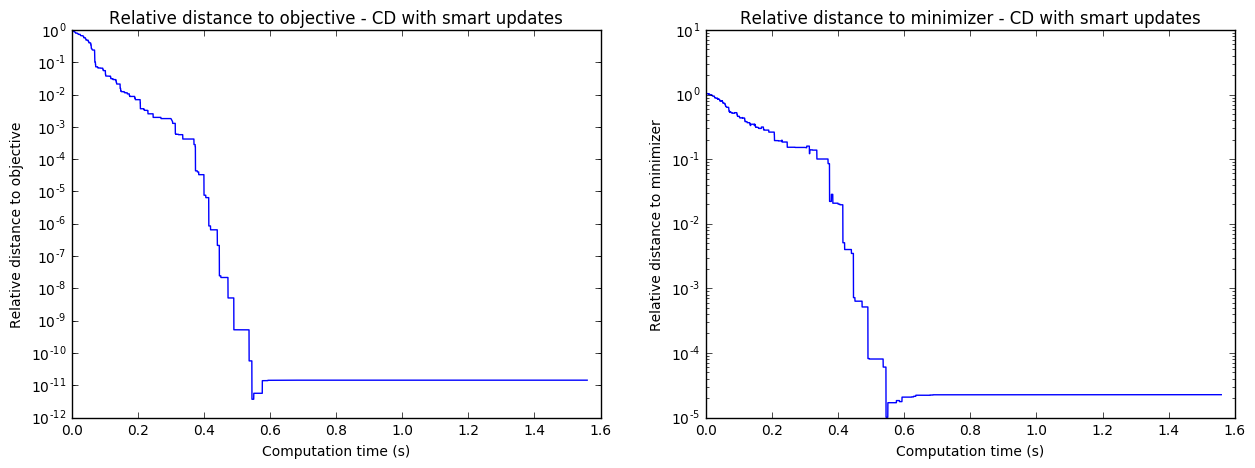

In [72]:
plt.figure(figsize=(15, 5))


plt.subplot(1, 2, 1)


plt.plot(tim_smart, dist_smart)
plt.yscale("log")
plt.title("Relative distance to objective - CD with smart updates")
plt.xlabel("Computation time (s)")
plt.ylabel("Relative distance to objective")


plt.subplot(1, 2, 2)

plt.plot(tim_smart, err_smart)
plt.yscale("log")
plt.title("Relative distance to minimizer - CD with smart updates")
plt.xlabel("Computation time (s)")
plt.ylabel("Relative distance to minimizer")
plt.show()

We observe that the smart updates CD slightly improve the computation time.

Now, let's compare the algorithms in terms of number of ietartions and in terms of computation time.

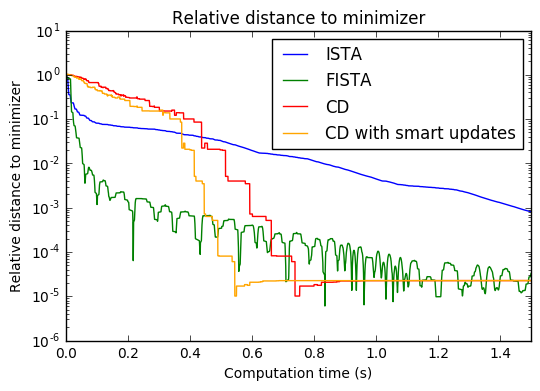

In [73]:
plt.plot(tim_ista, err_ista, color = 'b', label = 'ISTA')
plt.plot(tim_fista, err_fista, color = 'g', label = 'FISTA')
plt.plot(tim_cd, err_cd, color = 'r', label = 'CD')
plt.plot(tim_smart, err_smart, color = 'orange', label = 'CD with smart updates')
plt.yscale("log")
plt.title("Relative distance to minimizer")
plt.xlabel("Computation time (s)")
plt.ylabel("Relative distance to minimizer")
plt.xlim([0, 1.5])
plt.legend()
plt.show()

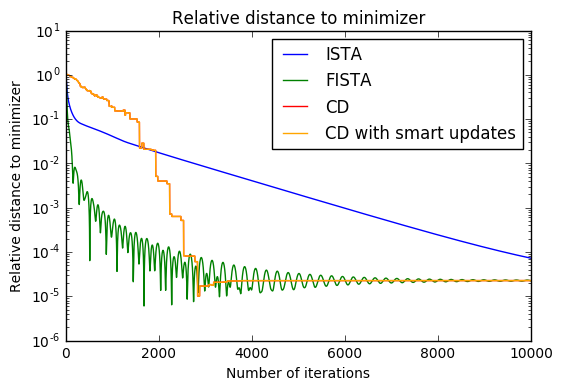

In [76]:
plt.plot(err_ista, color = 'b', label = 'ISTA')
plt.plot(err_fista, color = 'g', label = 'FISTA')
plt.plot(err_cd, color = 'r', label = 'CD')
plt.plot(err_smart, color = 'orange', label = 'CD with smart updates')
plt.yscale("log")
plt.title("Relative distance to minimizer")
plt.xlabel("Number of iterations")
plt.ylabel("Relative distance to minimizer")
plt.xlim([0, 10000])
plt.legend()
plt.show()

#### L-BFGS-B

Here also, we reuse the code from previous labs

In [81]:
#definition of the callback
def inspector(loss_fun, x_real, verbose=False):
    """A closure called to update metrics after each iteration."""
    objectives = []
    errors = []
    it = [0] # This is a hack to be able to modify 'it' inside the closure.
    def inspector_cl(xk):
        obj = loss_fun(xk) - f_min
        err = norm(xk - x_min)
        objectives.append(obj)
        errors.append(err)
        if verbose == True:
            if it[0] == 0:
                print(' | '.join([name.center(8) for name in ["it", "obj", "err"]]))
            if it[0] % (n_iter / 5) == 0:
                print(' | '.join([("%d" % it[0]).rjust(8), ("%.2e" % obj).rjust(8), ("%.2e" % err).rjust(8)]))
            it[0] += 1
    inspector_cl.obj = objectives
    inspector_cl.err = errors
    return inspector_cl

In [82]:
#Implementation of the inspector
def inspector(loss, mu_min, f_min, verbose=False):
    """A closure called to update metrics after each iteration."""
    objectives = []
    errors = []
    times = [0]
    it = [0]
    start = time.time()
    def inspector_cl(muk):
        
        obj = loss(muk) - f_min
        err = norm(muk - mu_min)
        objectives.append(obj)
        errors.append(err)
        times.append(time.time() - start)
        if verbose == True:
            if it[0] == 0:
                print(' | '.join([name.center(8) for name in ["it", "obj", "err"]]))
            if it[0] % 1000 == 0:
                print(' | '.join([("%d" % it[0]).rjust(8), ("%.2e" % obj).rjust(8), ("%.2e" % err).rjust(8)]))
            it[0] += 1
    inspector_cl.obj = objectives
    inspector_cl.err = errors
    inspector_cl.times = times
    return inspector_cl

In [85]:
start = time.time()
bfgs_inspector = inspector(total_loss, mu_bfgs, f_min, verbose=True)
mu_1, _, _ = fmin_l_bfgs_b(func=total_loss, x0=mu0, fprime=grad_svm,
                              maxiter=30000, callback=bfgs_inspector, bounds=[(0, C) for i in range(n)])

   it    |   obj    |   err   
       0 | 6.99e-01 | 9.25e-02


We plot the evolution of the relative distance to the objective and the relative distance to the minimizer, w.r.t. the number of iterations first, then w.r.t. the computation time, with a log scale.

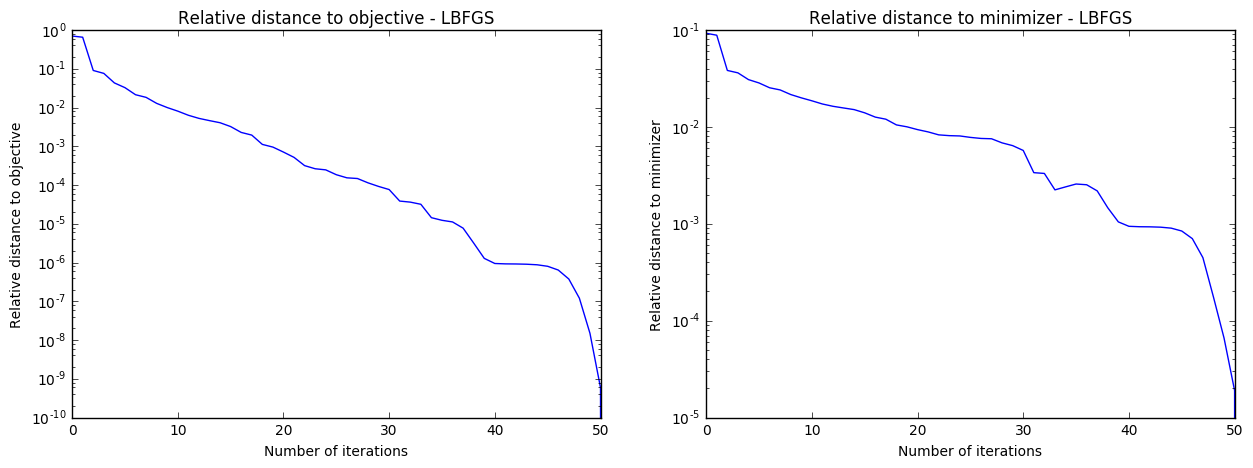

In [86]:
plt.figure(figsize=(15, 5))

plt.subplot(1, 2, 1)


plt.plot(bfgs_inspector.obj)
plt.yscale("log")
plt.title("Relative distance to objective - LBFGS")
plt.xlabel("Number of iterations")
plt.ylabel("Relative distance to objective")
plt.xlim([0, 50])


plt.subplot(1, 2, 2)

plt.plot(bfgs_inspector.err)
plt.yscale("log")
plt.title("Relative distance to minimizer - LBFGS")
plt.xlabel("Number of iterations")
plt.ylabel("Relative distance to minimizer")
plt.xlim([0, 50])
plt.show()

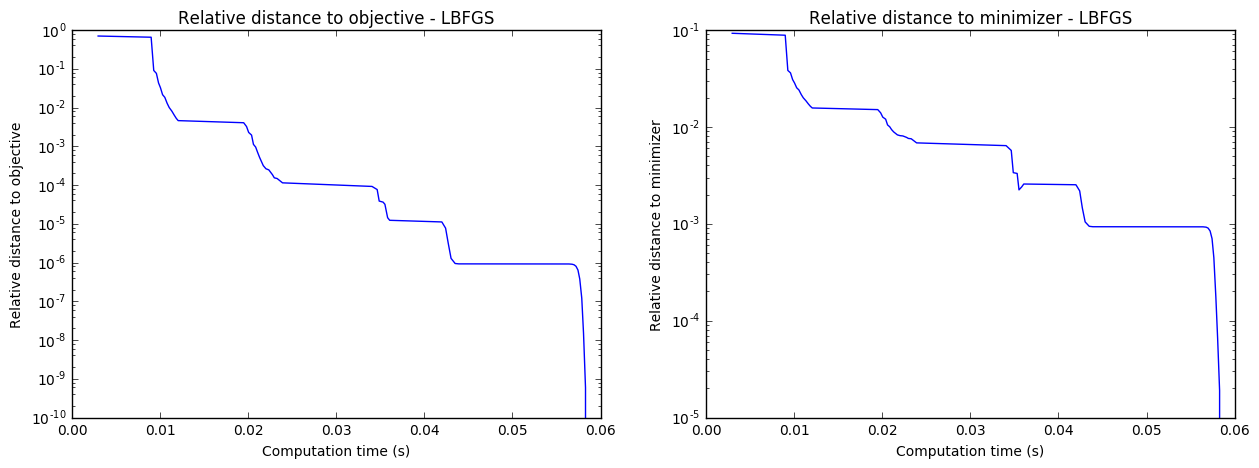

In [87]:
plt.figure(figsize=(15, 5))


plt.subplot(1, 2, 1)


plt.plot(bfgs_inspector.times[1:], bfgs_inspector.obj)
#plt.axis([0, np.max(tim_smart), 1, np.log(np.max(dist_smart[1:]))])
plt.yscale("log")
plt.title("Relative distance to objective - LBFGS")
plt.xlabel("Computation time (s)")
plt.ylabel("Relative distance to objective")


plt.subplot(1, 2, 2)

plt.plot(bfgs_inspector.times[1:], bfgs_inspector.err)
#plt.axis([0, np.max(tim_smart), 10**-15, np.log(np.max(err_smart[1:]))])
plt.yscale("log")
plt.title("Relative distance to minimizer - LBFGS")
plt.xlabel("Computation time (s)")
plt.ylabel("Relative distance to minimizer")
plt.show()

Let us plot the different algorithm convergences depending on the computation time, then on the number of iterations.

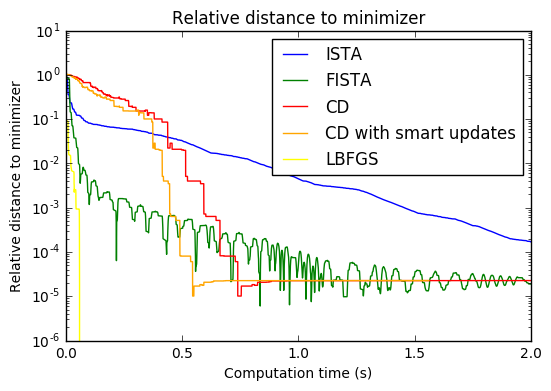

In [90]:
plt.plot(tim_ista, err_ista, color = 'b', label = 'ISTA')
plt.plot(tim_fista, err_fista, color = 'g', label = 'FISTA')
plt.plot(tim_cd, err_cd, color = 'r', label = 'CD')
plt.plot(tim_smart, err_smart, color = 'orange', label = 'CD with smart updates')
plt.plot(bfgs_inspector.times[1:], bfgs_inspector.err, color = 'yellow', label = 'LBFGS')
plt.yscale("log")
plt.title("Relative distance to minimizer")
plt.xlabel("Computation time (s)")
plt.ylabel("Relative distance to minimizer")
plt.xlim([0, 2])
plt.legend()
plt.show()

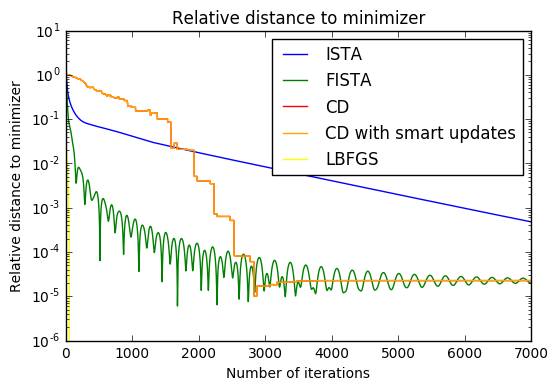

In [93]:
plt.plot(err_ista, color = 'b', label = 'ISTA')
plt.plot(err_fista, color = 'g', label = 'FISTA')
plt.plot(err_cd, color = 'r', label = 'CD')
plt.plot(err_smart, color = 'orange', label = 'CD with smart updates')
plt.plot(bfgs_inspector.err, color = 'yellow', label = 'LBFGS')

plt.yscale("log")
plt.title("Relative distance to minimizer")
plt.xlabel("Number of iterations")
plt.ylabel("Relative distance to minimizer")
plt.xlim([0, 7000])
plt.legend()
plt.show()

We observe first that LBFGS outperforms all other algorithms.
Then, we verify that FISTA converges faster tha ISTA, but slower than LBFGS.
CD is at first the slowest algorithm (with both smart & not smart updates), but it is quickly catching up with FISTA.
CD algorithm with smart update gives a slight improvement to regular CD algorithm (except in terms of number of iterations, where these two algorithms behave identically, as expected).